#  <u>Time series prediction of NYC taxi´s demand using Meta prophet</u>

### 1. Importacion de las librerias utilizadas:

In [78]:
import pandas as pd
import datetime as dt
import numpy as np
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot
from prophet import Prophet as ph
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px


### 2. Lectura de datos de entrada y determinación de fechas de inico y fin de la muestra:

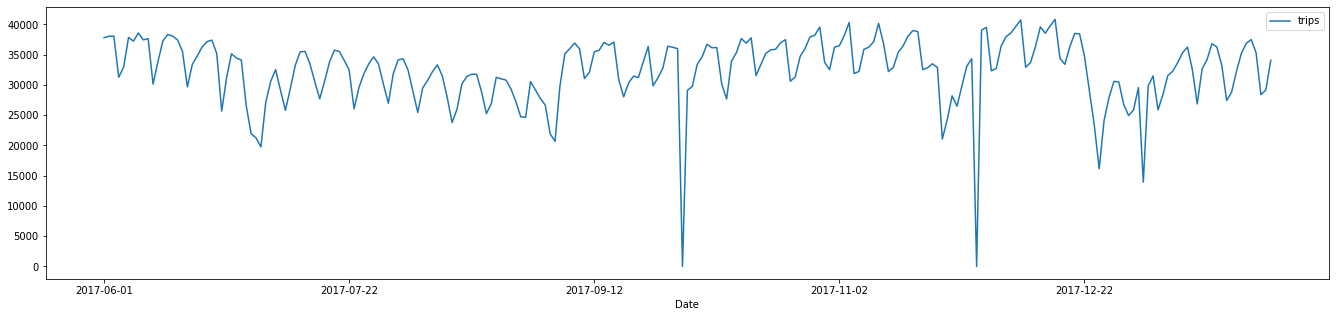

In [64]:
data = pd.read_csv("trips_day.csv")
data = data.drop("Unnamed: 0", axis=1)

end = "2017-06-01"
start = "2018-01-30"

data.plot(y = 'trips', x = "Date", figsize=(23,5))
pyplot.show()

### 3. Tratamiento de outliers


In [65]:
#funcion para calcular outliers
def outliers_obt(data, columna,cuartial1,cuartil2,valoriqr=1.5):
    ##calculamos los cuartiles 
    Q1 = data[columna].quantile(float(cuartial1))
    #print('Primer Cuartile', Q1)
    Q3 = data[columna].quantile(float(cuartil2))
    #print('Tercer Cuartile',Q3)
    IQR = Q3 - Q1
    #print('Rango intercuartile', IQR)

    ##calculamos los bigotes superior e inferior
    BI = (Q1 - valoriqr * IQR)
    #print('bigote Inferior \n', BI)
    BS = (Q3 + valoriqr * IQR)
    #print('bigote superior \n', BS)

    ##obtenemos una nueva tabla sin los outliers
    ubi_sin_out = data[(data[columna] >= BI) & (data[columna] <= BS)]
    return ubi_sin_out

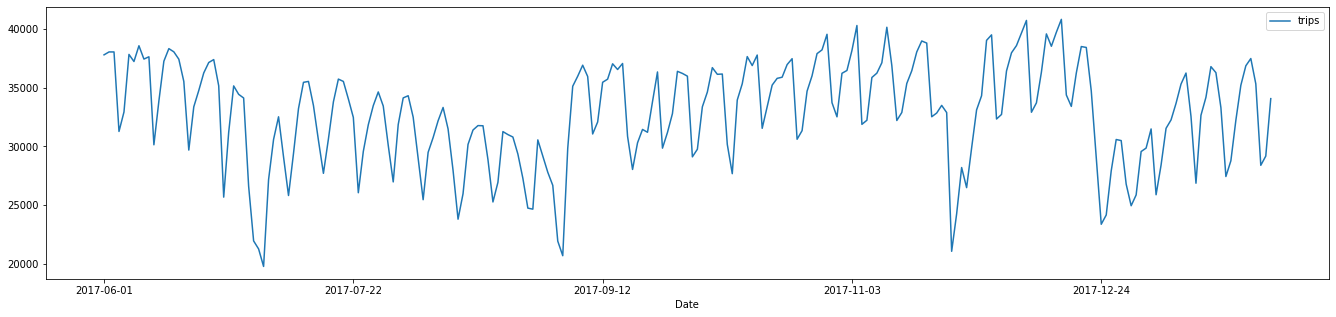

In [66]:
data=outliers_obt(data,'trips','0.25','0.75',valoriqr=2)

data.plot(y = 'trips', x = "Date", figsize=(23,5))
pyplot.show()

### 4. Entrenamiento del modelo:

In [67]:
data = data.rename(columns={'Date': 'ds'})
data = data.rename(columns={'trips': 'y'})

model = ph()
model.fit(data)

18:27:57 - cmdstanpy - INFO - Chain [1] start processing
18:27:57 - cmdstanpy - INFO - Chain [1] done processing


### 5. Predicciones realizas por el modelo:

In [29]:
future_dates = model.make_future_dataframe(periods=30)
future = model.predict(future_dates)

future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
255,2018-02-20,32028.586758,27832.788287,36162.140841
256,2018-02-21,33635.026336,29322.847411,37635.199377
257,2018-02-22,34456.508673,30272.174100,38618.357433
258,2018-02-23,34289.827490,30014.568188,38197.240262
259,2018-02-24,33113.182520,28867.833908,37306.398473
260,2018-02-25,27836.381111,23679.915451,31793.070201
261,2018-02-26,28895.297122,24726.318295,33294.555956
262,2018-02-27,31884.972366,27116.229816,36097.102132
263,2018-02-28,33491.411945,29073.852088,37591.151799
264,2018-03-01,34312.894281,29994.063912,38478.469717


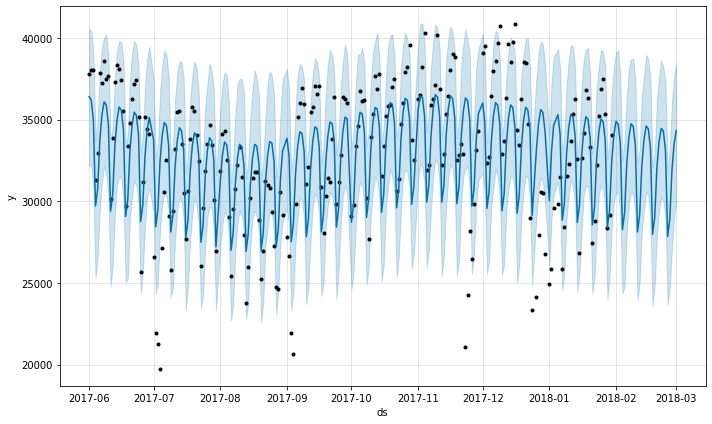

In [30]:
fig2 = model.plot(future)

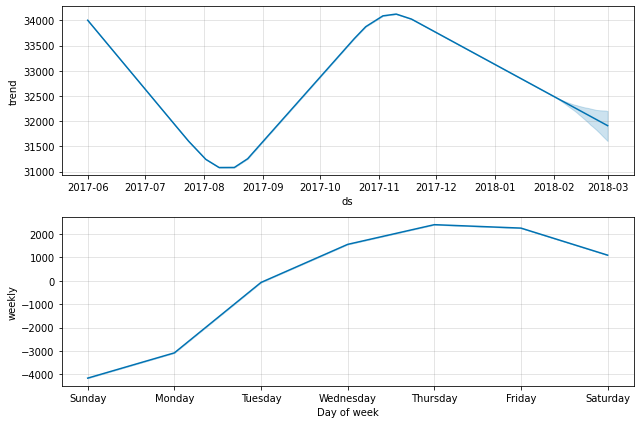

In [31]:
fig3 = model.plot_components(future)

In [86]:
plot_plotly(model, future)

### 6. validación cruzada para medir el error de pronóstico

In [37]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='60 days', period='15 days', horizon = '30 days')

  0%|          | 0/11 [00:00<?, ?it/s]

17:30:54 - cmdstanpy - INFO - Chain [1] start processing
17:30:55 - cmdstanpy - INFO - Chain [1] done processing
17:31:01 - cmdstanpy - INFO - Chain [1] start processing
17:31:01 - cmdstanpy - INFO - Chain [1] done processing
17:31:06 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:11 - cmdstanpy - INFO - Chain [1] start processing
17:31:11 - cmdstanpy - INFO - Chain [1] done processing
17:31:16 - cmdstanpy - INFO - Chain [1] start processing
17:31:16 - cmdstanpy - INFO - Chain [1] done processing
17:31:22 - cmdstanpy - INFO - Chain [1] start processing
17:31:22 - cmdstanpy - INFO - Chain [1] done processing
17:31:27 - cmdstanpy - INFO - Chain [1] start processing
17:31:27 - cmdstanpy - INFO - Chain [1] done processing
17:31:32 - cmdstanpy - INFO - Chain [1] start processing
17:31:32 - cmdstanpy - INFO - Chain [1] done processing
17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:38 - cmdstanpy - INFO - Chain [1]

In [38]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-08-04,34083.273009,30932.122338,36972.338854,32499,2017-08-03
1,2017-08-05,31725.353299,28499.805513,34769.689422,29008,2017-08-03
2,2017-08-06,26304.181387,23340.842319,29401.713460,25452,2017-08-03
3,2017-08-07,29340.453731,26062.617718,32248.556810,29495,2017-08-03
4,2017-08-08,32131.238133,29161.835865,35129.536761,30752,2017-08-03


In [101]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head(15)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,7.951012e+06,2819.753860,1939.172743,0.066708,0.034558,0.062511,0.844575
1,4 days,7.160540e+06,2675.918626,1773.369503,0.059257,0.030392,0.056237,0.812317
2,5 days,6.563852e+06,2562.001565,1752.319078,0.053319,0.030460,0.052132,0.780059
3,6 days,9.235083e+06,3038.927935,2276.219238,0.067716,0.040787,0.066907,0.716129
4,7 days,2.568813e+07,5068.345393,3514.993696,0.118300,0.063857,0.107350,0.695015
5,8 days,3.697539e+07,6080.739549,4357.206407,0.153737,0.088935,0.137138,0.668622
6,9 days,3.739437e+07,6115.093682,4269.507209,0.153344,0.076308,0.136474,0.686217
7,10 days,2.900716e+07,5385.829622,3772.328572,0.133224,0.075079,0.121627,0.689150
8,11 days,2.172846e+07,4661.379270,3232.633166,0.110104,0.057723,0.102009,0.687097
9,12 days,2.050225e+07,4527.941171,3310.243066,0.108226,0.087035,0.101304,0.695015


### Grafica del Error absoluto medio porcentual (Mean absolute percentage error) 

El error porcentual absoluto medio, también conocido como desviación porcentual absoluta media, es una medida de precisión de predicción de un método de predicción en estadística.

Los puntos muestran el porcentaje de error absoluto para cada predicción en df_cv. La línea azul muestra el MAPE, donde la media se toma sobre una ventana móvil de puntos. Vemos para este pronóstico que los errores entre el 10 y 20% son típicos para las predicciones de hasta un mes en el futuro.

In [46]:
import matplotlib.pyplot as plt


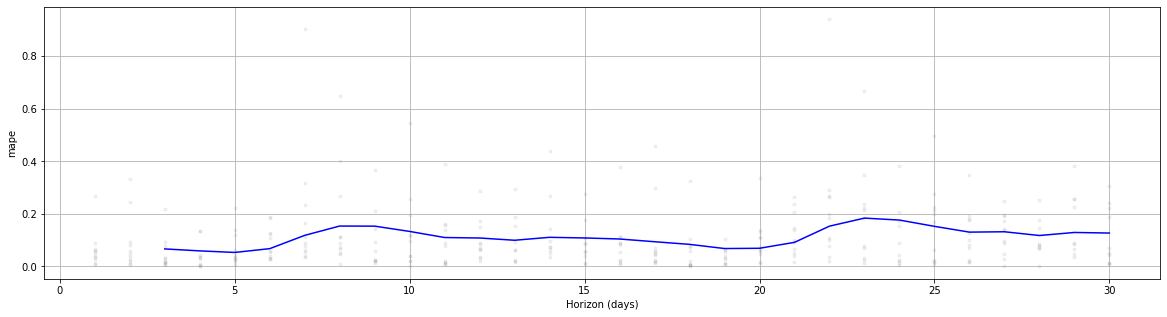

In [88]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape', figsize=(20,5))


In [118]:
df_p["mape"].mean()

0.11276816597969352